In [97]:
import os
import numpy as np
import datetime

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib

## PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

## Torchvision
from torchvision import datasets
from torchvision import transforms

import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger

from scipy.optimize import linear_sum_assignment
from scipy.sparse import coo_matrix

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


In [98]:
h = {  # hyperparameters
    'in_channels': 1,
    'num_pieces': 8,
    'image_size': 28,
    'hidden_channels': 32,
    'kernel_size': 5,
    'tau': 0.1,
    'n_sink_iter': 20,
    'epochs': 20,
    'learning_rate': 1e-4,
    'checkpoint_path': './saved_models',
    'dataset_path': './data',
    'batch_size': 64
}
train = True  # Set this to false if you only want to evaluate the model
use_wandb = True

In [99]:
def log_sinkhorn(log_alpha, n_iter):
    """Performs incomplete Sinkhorn normalization to log_alpha.
    By a theorem by Sinkhorn and Knopp [1], a sufficiently well-behaved  matrix
    with positive entries can be turned into a doubly-stochastic matrix
    (i.e. its rows and columns add up to one) via the successive row and column
    normalization.

    [1] Sinkhorn, Richard and Knopp, Paul.
    Concerning nonnegative matrices and doubly stochastic
    matrices. Pacific Journal of Mathematics, 1967
    Args:
      log_alpha: 2D tensor (a matrix of shape [N, N])
        or 3D tensor (a batch of matrices of shape = [batch_size, N, N])
      n_iters: number of sinkhorn iterations (in practice, as little as 20
        iterations are needed to achieve decent convergence for N~100)
    Returns:
      A 3D tensor of close-to-doubly-stochastic matrices (2D tensors are
        converted to 3D tensors with batch_size equals to 1)
    """
    for _ in range(n_iter):
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -1, keepdim=True)
        log_alpha = log_alpha - torch.logsumexp(log_alpha, -2, keepdim=True)
    return log_alpha.exp()


def matching(alpha):
    # Negate the probability matrix to serve as cost matrix. This function
    # yields two lists, the row and colum indices for all entries in the
    # permutation matrix we should set to 1.
    row, col = linear_sum_assignment(-alpha)

    # Create the permutation matrix.
    permutation_matrix = coo_matrix((np.ones_like(row), (row, col))).toarray()
    return torch.from_numpy(permutation_matrix)


def sample_gumbel(shape, device='cpu', eps=1e-20):
    """Samples arbitrary-shaped standard gumbel variables.
    Args:
      shape: list of integers
      eps: float, for numerical stability
    Returns:
      A sample of standard Gumbel random variables
    """
    u = torch.rand(shape, device=device)
    return -torch.log(-torch.log(u + eps) + eps)


def gumbel_sinkhorn(log_alpha, tau, n_iter):
    """ Sample a permutation matrix from the Gumbel-Sinkhorn distribution
    with parameters given by log_alpha and temperature tau.

    Args:
      log_alpha: Logarithm of assignment probabilities. In our case this is
        of dimensionality [num_pieces, num_pieces].
      tau: Temperature parameter, the lower the value for tau the more closely
        we follow a categorical sampling.
    """
    # Sample Gumbel noise.
    gumbel_noise = sample_gumbel(log_alpha.shape, device=log_alpha.device)

    # Apply the Sinkhorn operator!
    sampled_perm_mat = log_sinkhorn((log_alpha + gumbel_noise) / tau, n_iter)
    return sampled_perm_mat

In [100]:
def chunk_image(image: torch.Tensor, num_pieces: int):
    """Randomly chunk a single image.
    Args:
      image: Image [channels, height, width].

    Returns:
      pieces: Image chunks in their original positions. [num_pieces, channels,
        height // num_pieces, width // num_pieces]
      random_pieces: Image chunks in their randomly permuted positions.
      permute_index: List of permuted indices.
    """
    # Get image dimensions.
    height, width = image.shape[-2:]

    # Get piece dimensions.
    piece_height = height // num_pieces
    piece_width = width // num_pieces
    pieces = []

    # Obtain indices for each of the image chunks.
    for p_h in range(num_pieces):
        for p_w in range(num_pieces):
            left = p_w * piece_width
            right = left + piece_width
            top = p_h * piece_height
            bottom = top + piece_height
            piece = image[:, top:bottom, left:right]
            pieces.append(piece)

    pieces = torch.stack(pieces, 0)

    # Randomly permute the index of the pieces.
    permute_index = torch.randperm(num_pieces ** 2)
    random_pieces = pieces[permute_index]
    return pieces, random_pieces, permute_index


def batch_chunk_image(images: torch.Tensor, num_pieces: int):
    """Randomly chunk a batch of images.
    Args:
      image: Images [batch, channels, height, width].

    Returns:
      pieces: Batch of image chunks in their original positions. [batch,
        num_pieces, channels, height // num_pieces, width // num_pieces]
      random_pieces: Batch of image chunks in their randomly permuted positions.
         [batch, num_pieces, channels, height // num_pieces, width // num_pieces]
      permute_index: Batch of permutation lists. [batch, num_pieces**2]
    """
    batch_pieces, batch_random_pieces, batch_permute_index = [], [], []
    for image in images:
        pieces, random_pieces, permute_index = chunk_image(image, num_pieces)

        batch_pieces.append(pieces)
        batch_random_pieces.append(random_pieces)
        batch_permute_index.append(permute_index)
    return torch.stack(batch_pieces, 0), torch.stack(batch_random_pieces, 0), torch.stack(batch_permute_index, 0)


def inverse_permutation_for_image(X, permutation_matrix):
    # temp, make `permutation_matrix` transposed
    # permutation_matrix = permutation_matrix.transpose(1, 2)
    
    """Apply the inverse of a permutation (its transpose) to a batch of image
       chunks.
    Args:
      X: Batched sets of image chunks. [batch, num_pieces, channels, height, width]
      permutation_matrix: float, for numerical stability

    Returns:
      Permuted set of image chunks.
    """
    return torch.einsum("bpq,bpchw->bqchw", (permutation_matrix, X)).contiguous()


# Example of `inverse_permutation_for_image`
X = torch.rand((64, 4, 1, 14, 14))
permutation_matrix = torch.rand((64, 4, 4))
first1 = inverse_permutation_for_image(X, permutation_matrix)[0]  # (4, 1, 14, 14)
first1 = first1.flatten()  # (1, 784)

X_first = X[0]  # (4, 1, 14, 14)
X_first = X_first.flatten(start_dim=1)  # (4, 196)

permutation_matrix_first = permutation_matrix[0]  # (4, 4)
permutation_matrix_first = permutation_matrix_first.T  # (4, 4)
X_first_permuted = torch.mm(permutation_matrix_first, X_first)  # (4, 196)

X_first_permuted = X_first_permuted.reshape(4, 1, 14, 14)  # (4, 1, 14, 14)
X_first_permuted = X_first_permuted.flatten()  # (1, 784)

# e.g.: P^T*X = \tilde{X}, with row(X) = all pixels of a single piece
torch.allclose(first1, X_first_permuted)

True

In [101]:
class SinkhornConvNet(pl.LightningModule):
    def __init__(self, in_channels, num_pieces, image_size, hidden_channels, kernel_size, tau=1.0, n_sink_iter=20):
        super().__init__()

        # store these for later use.
        self.tau = tau
        self.n_sink_iter = n_sink_iter
        self.num_pieces = num_pieces

        self.g_1 = nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels, kernel_size, padding=kernel_size // 2),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.BatchNorm2d(hidden_channels)
        )

        # calculate the size of a single piece in pixels
        piece_size = image_size // num_pieces

        # calculate the size of a single piece in pixels after 1 max pooling
        piece_size_after_conv = (piece_size) // (2 * 1)

        self.g_2 = nn.Linear(piece_size_after_conv ** 2 * hidden_channels, num_pieces ** 2, bias=False)

    def forward(self, batch_pieces):
        # in: (64, 4, 1, 14, 14): 4 pieces of 14x14 images
        # out: (64, 4, 1, 14, 14), (64, 4, 4): 4 pieces of 14x14 images and permutation matrices
        batch_size = batch_pieces.shape[0]

        # Switch batch and piece dimensions. We want to apply the same network to each of the pieces.
        pieces = batch_pieces.transpose(0, 1).contiguous()  # (4, 64, 1, 14, 14)

        # Apply g_1 to each of the pieces.
        conv_pieces = []
        for piece in pieces:
            piece = self.g_1(piece)
            conv_piece = piece.reshape(batch_size, -1)
            conv_pieces.append(conv_piece)

        # Apply g_2 to each of the pieces.
        latent_pieces = []
        for piece in conv_pieces:
            latent_piece = self.g_2(piece)
            latent_pieces.append(latent_piece)

        # Create a matrix of log unnormalized assignment probabilities. After this
        # the batch dimension is batch in the first position.
        log_alphas = torch.stack(latent_pieces, 1)  # (64, 4, 4)

        # During training, we sample from the Gumbel-Sinkhorn distribution.
        if self.training:
            permutation_matrices = gumbel_sinkhorn(log_alphas, tau=self.tau, n_iter=self.n_sink_iter)

        # During eval, we solve the linear assignment problem.
        else:
            permutation_matrices = torch.stack([
                matching(log_alpha)
                for log_alpha in log_alphas.cpu().detach().numpy()]
            ).float().to(log_alphas.device)

        # We obtain the ordered pieces as predicted by our network
        ordered_pieces = inverse_permutation_for_image(batch_pieces, permutation_matrices)

        # Return the ordered pieces, along with the predicted permutation.
        # We will inspect the predicted permutation matrices during test time.
        return ordered_pieces, permutation_matrices

    def training_step(self, batch, batch_idx):
        inputs, _ = batch
        pieces, random_pieces, _ = batch_chunk_image(inputs, self.num_pieces)
        pieces, random_pieces = pieces.to(self.device), random_pieces.to(self.device)
        ordered_pieces, _ = self(random_pieces)
        loss = torch.nn.functional.mse_loss(ordered_pieces, pieces, reduction='sum')
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4, eps=1e-8)


# Example usage
model = SinkhornConvNet(
    in_channels=1, num_pieces=2, image_size=28, hidden_channels=32, kernel_size=5, tau=0.1, n_sink_iter=20)

random_pieces = torch.rand((64, 4, 1, 14, 14))
res1, res2 = model(random_pieces)
res1.shape, res2.shape

(torch.Size([64, 4, 1, 14, 14]), torch.Size([64, 4, 4]))

In [102]:
device = torch.device('cuda')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(trainset, h['batch_size'], drop_last=True, shuffle=True)
test_loader = DataLoader(testset, h['batch_size'], drop_last=False, shuffle=True)

In [103]:
date_identifier = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

if use_wandb:
    wandb_logger = WandbLogger()
    wandb.init(project='sinkhorn_netw',
               name=f'sinkhorn_mnist_{h["num_pieces"]}_pieces_{date_identifier}')

    wandb.config.update(h)

# Initialize the model
model = SinkhornConvNet(in_channels=h['in_channels'],
                        num_pieces=h['num_pieces'],
                        image_size=h['image_size'],
                        hidden_channels=h['hidden_channels'],
                        kernel_size=h['kernel_size'],
                        tau=h['tau'],
                        n_sink_iter=h['n_sink_iter'])

if train:
    # log_progress_callback; simply prints the progress to the console
    class LogProgressCallback(pl.Callback):
        def on_train_epoch_end(self, trainer, pl_module):
            print(f"Epoch {trainer.current_epoch}, "
                  f"Loss {trainer.callback_metrics['train_loss']:.2f}")


    # Pass the callback to the Trainer

    # Pass the callback to the Trainer
    trainer = pl.Trainer(max_epochs=h['epochs'], callbacks=[LogProgressCallback()],
                         logger=wandb_logger if use_wandb else None)

    # Train the model
    trainer.fit(model, train_loader)

    # Save the model
    torch.save(model.state_dict(), os.path.join(h['checkpoint_path'], 'model.pth'))

    # Finish the run if we it was running
    if wandb.run is not None:
        wandb.finish()


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | g_1  | Sequential | 896   
1 | g_2  | Linear     | 2.0 K 
------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Loss 59345.79
Epoch 1, Loss 47794.86
Epoch 2, Loss 48249.23
Epoch 3, Loss 43408.73
Epoch 4, Loss 47246.44
Epoch 5, Loss 48970.45
Epoch 6, Loss 49926.63
Epoch 7, Loss 46394.09
Epoch 8, Loss 49129.89
Epoch 9, Loss 45116.65
Epoch 10, Loss 47061.22
Epoch 11, Loss 48443.78
Epoch 12, Loss 44098.48
Epoch 13, Loss 45729.03
Epoch 14, Loss 47385.88
Epoch 15, Loss 48803.26
Epoch 16, Loss 46570.28
Epoch 17, Loss 45688.52
Epoch 18, Loss 45219.79


`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19, Loss 46217.16


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train_loss,█▅▄▃▄▃▃▂▃▃▃▂▂▃▄▂▃▃▂▂▁▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▃▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,19
train_loss,46526.86719
trainer/global_step,18699


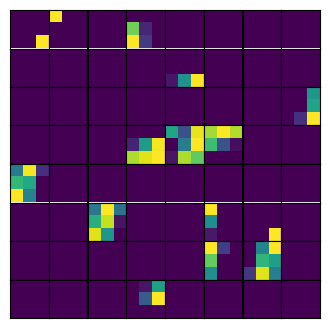

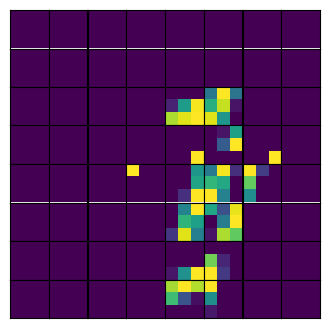

In [104]:
model.load_state_dict(torch.load("./saved_models/model.pth"))

image_batch, _ = next(iter(test_loader))
pieces, random_pieces, perm_list = batch_chunk_image(image_batch, h['num_pieces'])
# pieces, random_pieces = pieces.to(device), random_pieces.to(device)

# Make sure we are evaluating!
model.eval()

# Predict the correctly ordered pieces.
predicted_pieces, _ = model(random_pieces)

# Select an image from the batch.
batch_idx = 3

# Plot the original scrambed image.
figs, axs = plt.subplots(h['num_pieces'], h['num_pieces'], figsize=(4, 4), sharex=True, sharey=True)
# remove x, y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for idx, piece in enumerate(random_pieces[batch_idx]):
    axs[idx // h['num_pieces'], idx % h['num_pieces']].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Plot the predicted reconstructed image.
figs, axs = plt.subplots(h['num_pieces'], h['num_pieces'], figsize=(4, 4), sharex=True, sharey=True)
# remove x, y ticks
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    
for idx, piece in enumerate(predicted_pieces[batch_idx]):
    axs[idx // h['num_pieces'], idx % h['num_pieces']].imshow(piece.cpu().squeeze())
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
